**Imports & Installations**

In [ ]:
import sys
import subprocess
import random
import numpy as np
import pandas as pd
from collections import defaultdict

# --- VISUALIZATION LIBRARIES ---
import matplotlib.pyplot as plt
import seaborn as sns

# Install libraries if missing
def install(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("Checking dependencies...")
install("optuna")
install("pytorch_tabnet")
install("xgboost")
install("lightgbm")
install("imblearn")
install("matplotlib")
install("seaborn")

from sklearn.utils.class_weight import compute_class_weight

# Core ML
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, roc_curve, auc, confusion_matrix
)

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier

# Tree Models
import xgboost as xgb
import lightgbm as lgb

# Optimization
import optuna

Checking dependencies...


**Config**

In [ ]:
SEED = 42
def set_seeds(seed=SEED):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()

Encoder = "Label Encoder"
TRIALS = 30

**Load and Proccess Data**

In [ ]:
# Load Bank Churn Dataset
df_raw = pd.read_csv('Customer-Churn-Records.csv')

# --- FEATURE ENGINEERING ---

# 1. Ratios (Financial Health)
df_raw['BalanceSalaryRatio'] = df_raw['Balance'] / (df_raw['EstimatedSalary'] + 1)
df_raw['TenureByAge'] = df_raw['Tenure'] / (df_raw['Age'] + 1)
df_raw['CreditScoreGivenAge'] = df_raw['CreditScore'] / (df_raw['Age'] + 1)

# 2. Behavioral Flags (The "Death Zone")
# 2 is the sweet spot. 3 or 4 is incredibly dangerous.
df_raw['HighRiskProducts'] = (df_raw['NumOfProducts'] >= 3).astype(int)

# 3. Demographic Interactions
# Combine Geography and Gender to capture the "German Female" risk group
df_raw['Geo_Gender'] = df_raw['Geography'] + "_" + df_raw['Gender']

print("Added: Ratios, HighRiskProducts, and Geo_Gender interaction.")
# ------------------------------

# Drop only IDs/Names that are obviously not features
df_raw = df_raw.drop(columns=['RowNumber', 'CustomerId', 'Surname'], errors='ignore')

print(f"Dataset shape: {df_raw.shape}")

# 1. Define Features and Target
target_col = 'Exited' # CHANGED from 'churn'
df_raw[target_col] = df_raw[target_col].astype(int)
X_raw = df_raw.drop(columns=[target_col])
# Ensure target is integer
Y = df_raw[target_col].values.astype(int)

# ---------------------------

# 2. Explicitly define categorical columns
cat_cols = ['Geography', 'Gender', 'Card Type', 'Geo_Gender']
available_cat_cols = [c for c in cat_cols if c in X_raw.columns]
print(f"Categorical Columns to Encode: {available_cat_cols}")

# 3. Apply Encoding
df_final = X_raw.copy()

if Encoder == "Label Encoder":
    le = LabelEncoder()
    for col in available_cat_cols:
        df_final[col] = le.fit_transform(df_final[col].astype(str))
        print(f"Encoded {col}: {df_final[col].unique()}")
    X = df_final.values
else:
    X = df_final.values

# 4. Helper for class weights
def get_adaptive_weights(y):
    """
    Returns weights in two formats:
    1. dict: {0: w0, 1: w1} (For Keras, TabNet)
    2. float: scale_pos_weight (For XGBoost, LightGBM, PyTorch Loss)
    """
    neg_count, pos_count = np.bincount(y)
    total = neg_count + pos_count

    # Format 1: Dictionary (Balanced)
    w0 = total / (2 * neg_count)
    w1 = total / (2 * pos_count)
    weight_dict = {0: w0, 1: w1}

    # Format 2: Scale Factor (Neg/Pos)
    scale_pos_weight = neg_count / pos_count

    return weight_dict, scale_pos_weight

# 5. Helper for threshold
def get_optimal_threshold(y_true, y_prob):
    """
    Finds the threshold that maximizes F1 score on the provided data.
    Now searches from 0.10 up to 0.90 to handle class-weighted probability shifts.
    """
    best_thresh = 0.5
    best_f1 = 0.0

    # CHANGED: Search from 0.1 up to 0.91 (inclusive of 0.90)
    for thresh in np.arange(0.1, 0.91, 0.01):
        y_pred = (y_prob >= thresh).astype(int)
        score = f1_score(y_true, y_pred)

        # Using >= to keep the highest threshold if scores are identical (optional preference)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh

    return best_thresh

Added: Ratios, HighRiskProducts, and Geo_Gender interaction.
Dataset shape: (10000, 20)
Categorical Columns to Encode: ['Geography', 'Gender', 'Card Type', 'Geo_Gender']
Encoded Geography: [0 2 1]
Encoded Gender: [0 1]
Encoded Card Type: [0 1 3 2]
Encoded Geo_Gender: [0 4 5 1 2 3]


**EDA**

--- STANDARD EDA FOR: Exited ---


/tmp/ipython-input-2950761102.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[target_col], palette="viridis")


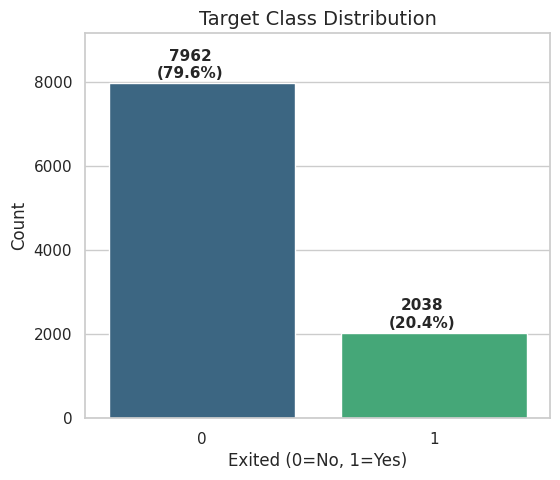

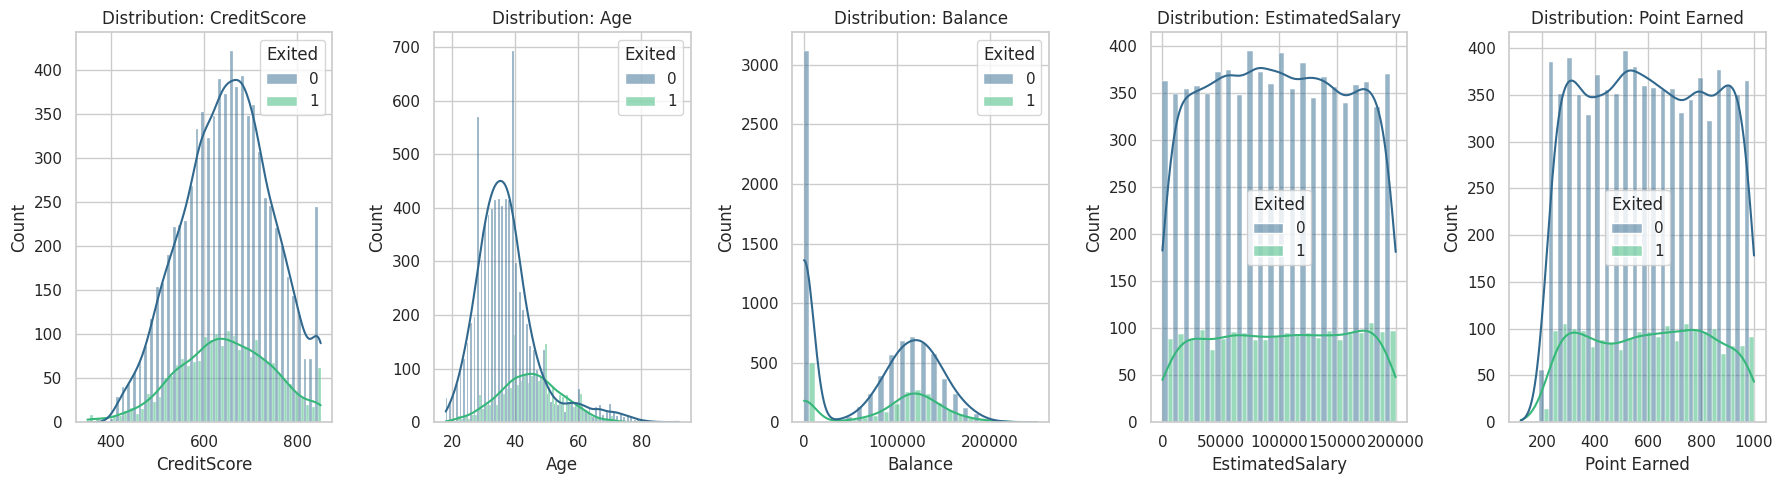

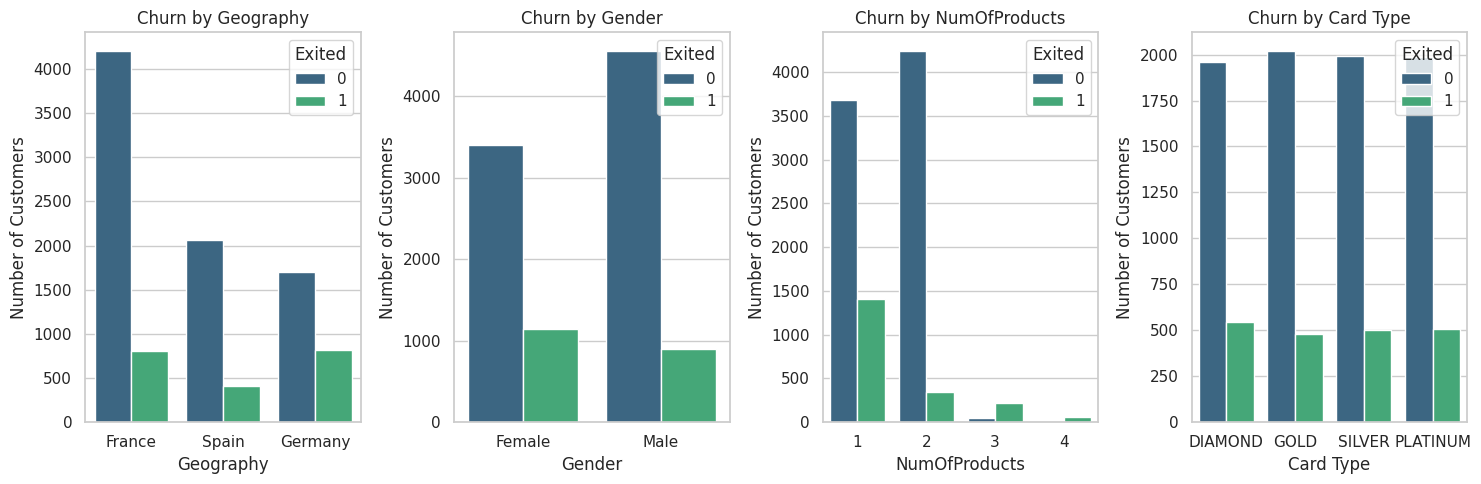

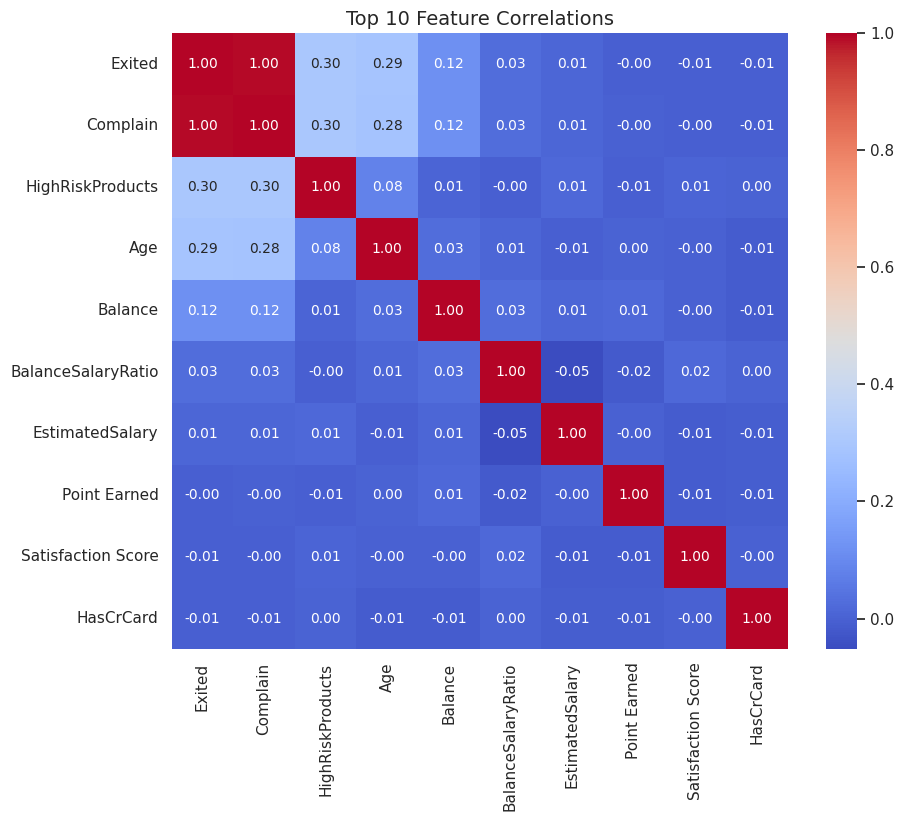

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a clean, standard visual style
sns.set_theme(style="whitegrid")

def run_standard_eda(df, target_col):
    print(f"--- STANDARD EDA FOR: {target_col} ---")

    # 1. CLASS BALANCE (Counts + Percentages)
    plt.figure(figsize=(6, 5))
    ax = sns.countplot(x=df[target_col], palette="viridis")
    plt.title("Target Class Distribution", fontsize=14)
    plt.xlabel(f"{target_col} (0=No, 1=Yes)")
    plt.ylabel("Count")

    # Calculate total to compute percentages
    total = len(df)

    # Add labels on top (Count + %)
    for p in ax.patches:
        count = int(p.get_height())
        pct = 100 * count / total
        ax.annotate(f'{count}\n({pct:.1f}%)',
                    (p.get_x() + 0.35, p.get_height() + 50),
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.ylim(0, df[target_col].value_counts().max() * 1.15) # Add headroom for text
    plt.show()

    # 2. NUMERICAL DISTRIBUTIONS (Histograms)
    # CHANGED: Bank numerical features
    num_features = ["CreditScore", "Age", "Balance", "EstimatedSalary", "Point Earned"]
    valid_nums = [c for c in num_features if c in df.columns]

    if valid_nums:
        fig, axes = plt.subplots(1, len(valid_nums), figsize=(18, 5))
        if len(valid_nums) == 1: axes = [axes]

        for ax, feature in zip(axes, valid_nums):
            sns.histplot(data=df, x=feature, hue=target_col, multiple="dodge",
                         kde=True, palette="viridis", ax=ax)
            ax.set_title(f"Distribution: {feature}")

        plt.tight_layout()
        plt.show()

    # 3. CATEGORICAL BREAKDOWN (Grouped Bars)
    # CHANGED: Bank categorical features
    cat_features = ["Geography", "Gender", "NumOfProducts", "Card Type"]
    valid_cats = [c for c in cat_features if c in df.columns]

    if valid_cats:
        # Adjusted figure size for bank categories
        fig, axes = plt.subplots(1, len(valid_cats), figsize=(15, 5))
        if len(valid_cats) == 1: axes = [axes]

        for ax, feature in zip(axes, valid_cats):
            sns.countplot(data=df, x=feature, hue=target_col, palette="viridis", ax=ax)
            ax.set_title(f"Churn by {feature}")
            ax.set_ylabel("Number of Customers")
            ax.legend(title=target_col, loc='upper right')

        plt.tight_layout()
        plt.show()

    # 4. CORRELATION MATRIX
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.shape[1] > 1:
        corr = numeric_df.corr()
        if target_col in corr.columns:
            # CHANGED: Show top 10 correlated features
            cols = corr.nlargest(10, target_col)[target_col].index
            cm = np.corrcoef(df[cols].values.T)

            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                        annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,
                        cmap="coolwarm")
            plt.title("Top 10 Feature Correlations", fontsize=14)
            plt.show()

# --- EXECUTE ---
df_raw[target_col] = df_raw[target_col].astype(int)
run_standard_eda(df_raw, target_col)

In [ ]:
# 1. Identify columns to drop
# We drop 'Complain' because EDA will show it is a leak (~1 correlation)
cols_to_drop = [
    'Complain'
]

print(f"Dropping redundant features: {cols_to_drop}")

# 2. Remove them from the dataframe
df_final = df_raw.drop(columns=cols_to_drop)

# 3. Verify the drop
print(f"New shape: {df_final.shape}")

# RE-DEFINE X AND Y
target_col = 'Exited'

# Define X (features) and Y (target) based on the NEW dataframe
X_raw = df_final.drop(columns=[target_col])
Y = df_final[target_col].values.astype(int)

# Re-identify categorical columns (they might still exist)
# CHANGED: Bank Categories
cat_cols = ['Geography', 'Gender', 'Card Type', 'Geo_Gender']
available_cat_cols = [c for c in cat_cols if c in X_raw.columns]

# Re-Encode
if Encoder == "Label Encoder":
    le = LabelEncoder()
    # Apply encoding to the remaining data
    for col in available_cat_cols:
        X_raw[col] = le.fit_transform(X_raw[col].astype(str))

    X = X_raw.values
else:
    X = X_raw.values

print("Feature selection complete. Redundant columns removed.")

Dropping redundant features: ['Complain']
New shape: (10000, 19)
Feature selection complete. Redundant columns removed.


**Model Definitions**

In [ ]:
# --- A. MLP-Attention (Keras) ---
def feature_attention(inputs, reduction_ratio=4):
    hidden_units = max(1, inputs.shape[-1] // reduction_ratio)
    x = layers.Dense(hidden_units, activation='relu')(inputs)
    x = layers.Dense(inputs.shape[-1], activation='sigmoid')(x)
    return layers.Multiply()([inputs, x])

def build_mlp_att(hp, input_dim):
    hidden_units = hp['hidden_units']
    dropout_rate = hp['dropout_rate']
    lr = hp['learning_rate']
    l2_reg = hp['l2_regularization']

    inputs = layers.Input(shape=(input_dim,))
    x = feature_attention(inputs)

    for units in [hidden_units, hidden_units // 2]:
        x = layers.Dense(units, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

# --- B. FT-Transformer (PyTorch) ---
class FTTransformerPyTorch(nn.Module):
    def __init__(self, input_dim, d_token=128, n_layers=3, n_heads=8, dropout=0.1):
        super(FTTransformerPyTorch, self).__init__()
        self.feature_embeddings = nn.ModuleList([nn.Linear(1, d_token) for _ in range(input_dim)])
        self.layer_norm_input = nn.LayerNorm(d_token)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_token))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token, nhead=n_heads, dim_feedforward=d_token * 4,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_token, 64), nn.ReLU(), nn.Dropout(dropout), nn.Linear(64, 1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        tokens = [emb(x[:, i].unsqueeze(-1)) for i, emb in enumerate(self.feature_embeddings)]
        x_tokens = torch.stack(tokens, dim=1)
        x_tokens = self.layer_norm_input(x_tokens)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x_tokens = torch.cat([cls_tokens, x_tokens], dim=1)
        x_encoded = self.transformer(x_tokens)
        return self.classifier(x_encoded[:, 0, :])

def train_pytorch_model(model, train_loader, val_loader, epochs, lr, device, pos_weight_val=1.0):
    model = model.to(device)

    # NEW: Apply Class Weight to Loss Function
    pos_weight_tensor = torch.tensor([pos_weight_val]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_auc = 0
    patience, counter = 10, 0
    best_state = None

    for epoch in range(epochs):
        model.train()
        for X_b, y_b in train_loader:
            X_b, y_b = X_b.to(device), y_b.to(device).float()
            optimizer.zero_grad()
            loss = criterion(model(X_b).squeeze(), y_b)
            loss.backward()
            optimizer.step()

        # ... (Rest of validation logic remains the same) ...
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
             for X_b, y_b in val_loader:
                X_b = X_b.to(device)
                out = model(X_b).squeeze()
                val_preds.extend(torch.sigmoid(out).cpu().numpy())
                val_targets.extend(y_b.numpy())

        auc_score = roc_auc_score(val_targets, val_preds)
        if auc_score > best_auc:
            best_auc = auc_score
            best_state = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
            if counter >= patience: break

    if best_state: model.load_state_dict(best_state)
    return model, best_auc

def predict_pytorch(model, X, device):
    model.eval()
    X_t = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        out = model(X_t).squeeze()
        probs = torch.sigmoid(out).cpu().numpy()
    return probs

**Unified Optuna Tuning**

In [ ]:
def tune_hyperparameters(X, Y, model_type):
    print(f"\nTUNING HYPERPARAMETERS FOR: {model_type}")

    X_tune, X_val, Y_tune, Y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=SEED)
    scaler = StandardScaler()
    X_tune = scaler.fit_transform(X_tune)
    X_val = scaler.transform(X_val)

    # CALCULATE WEIGHTS
    weight_dict, scale_pos_weight = get_adaptive_weights(Y_tune)

    def objective(trial):
        if model_type == "MLP-Attention":
            tf.keras.backend.clear_session()
            params = {
                'hidden_units': trial.suggest_categorical('hidden_units', [128, 256]),
                'dropout_rate': trial.suggest_float('dropout_rate', 0.2, 0.5),
                'learning_rate': trial.suggest_categorical('learning_rate', [1e-3, 5e-4]),
                'l2_regularization': trial.suggest_float('l2_regularization', 1e-5, 1e-3, log=True)
            }
            model = build_mlp_att(params, X_tune.shape[1])
            early = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

            # class_weight
            hist = model.fit(X_tune, Y_tune, validation_data=(X_val, Y_val),
                             epochs=20, batch_size=64, callbacks=[early], verbose=0,
                             class_weight=weight_dict) # <--- NEW
            return max(hist.history['val_AUC'])

        elif model_type == "FT-Transformer":
            d_token = trial.suggest_categorical('d_token', [64, 128])
            n_layers = trial.suggest_int('n_layers', 2, 3)
            dropout = trial.suggest_float('dropout', 0.1, 0.3)
            lr = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
            batch_size = trial.suggest_categorical('batch_size', [64, 128])

            model = FTTransformerPyTorch(X_tune.shape[1], d_token=d_token, n_layers=n_layers, dropout=dropout)

            train_ds = TensorDataset(torch.FloatTensor(X_tune), torch.LongTensor(Y_tune))
            val_ds = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(Y_val))
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_ds, batch_size=batch_size)

            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

            # pos_weight_val
            _, best_auc = train_pytorch_model(model, train_loader, val_loader, 20, lr, device,
                                              pos_weight_val=scale_pos_weight) # <--- NEW
            return best_auc

        elif model_type == "TabNet":
            # TabNet handles weights internally via fit(weights=...)
            params = {
                'n_d': trial.suggest_int('n_d', 16, 64, step=16),
                'n_a': trial.suggest_int('n_a', 16, 64, step=16),
                'gamma': trial.suggest_float('gamma', 1.0, 1.5),
                'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-4, 1e-2, log=True),
                'lr': trial.suggest_categorical('learning_rate', [0.02, 0.01])
            }
            clf = TabNetClassifier(n_d=params['n_d'], n_a=params['n_a'], gamma=params['gamma'],
                                   lambda_sparse=params['lambda_sparse'],
                                   optimizer_params=dict(lr=params['lr']), verbose=0)

            clf.fit(X_tune, Y_tune, eval_set=[(X_val, Y_val)],
                    max_epochs=20, patience=5, batch_size=256, eval_metric=['auc'],
                    weights=weight_dict)

            val_auc_key = next(k for k in clf.history.history.keys() if "val" in k and "auc" in k)
            return max(clf.history[val_auc_key])

        elif model_type == "XGBoost":
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'scale_pos_weight': scale_pos_weight,
                'eval_metric': 'auc', 'objective': 'binary:logistic', 'use_label_encoder': False
            }
            model = xgb.XGBClassifier(**params)
            model.fit(X_tune, Y_tune, eval_set=[(X_val, Y_val)], verbose=False)
            return roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])

        elif model_type == "LightGBM":
            params = {
                'num_leaves': trial.suggest_int('num_leaves', 20, 100),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'scale_pos_weight': scale_pos_weight,
                'metric': 'auc', 'objective': 'binary', 'verbose': -1
            }
            model = lgb.LGBMClassifier(**params)
            model.fit(X_tune, Y_tune, eval_set=[(X_val, Y_val)], callbacks=[lgb.early_stopping(10, verbose=False)])
            return roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=TRIALS)
    return study.best_params

**K-Fold Cross-Validation Evaluation**

In [ ]:
def kfold_evaluation(X, Y, best_params, model_type):
    print(f"\nRUNNING K-FOLD CV FOR: {model_type}")

    metrics = defaultdict(list)
    fold_thresholds = [] # <--- NEW: List to track the best threshold for each fold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Store all predictions for Global ROC
    all_y_true = []
    all_y_prob = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, Y), 1):
        print(f"Fold {fold}/10...", end=" ")

        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]

        # Scale
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # CALCULATE WEIGHTS
        weight_dict, scale_pos_weight = get_adaptive_weights(Y_train)

        # --- IMPORTANT: Create Validation Split for Threshold Tuning ---
        X_tr, X_val, Y_tr, Y_val = train_test_split(
            X_train, Y_train, test_size=0.1, stratify=Y_train, random_state=SEED
        )

        # Initialize threshold vars
        best_thresh = 0.5

        # --- TRAIN MODELS ---
        if model_type == "MLP-Attention":
            model = build_mlp_att(best_params, X_tr.shape[1])
            early = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')

            # 1. Fit on sub-train (X_tr), validate on X_val
            model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val), epochs=100, batch_size=32,
                      callbacks=[early], verbose=0, class_weight=weight_dict)

            # 2. Find best threshold using Validation Data
            Y_val_prob = model.predict(X_val, verbose=0).flatten()
            best_thresh = get_optimal_threshold(Y_val, Y_val_prob)

            # 3. Predict on Test
            Y_prob = model.predict(X_test, verbose=0).flatten()

        elif model_type == "FT-Transformer":
            # Prepare PyTorch Datasets
            model = FTTransformerPyTorch(X_tr.shape[1],
                                         d_token=best_params['d_token'],
                                         n_layers=best_params['n_layers'],
                                         dropout=best_params['dropout'])

            train_ds = TensorDataset(torch.FloatTensor(X_tr), torch.LongTensor(Y_tr))
            val_ds = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(Y_val))

            train_loader = DataLoader(train_ds, batch_size=best_params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_ds, batch_size=best_params['batch_size'])

            # 1. Train
            model, _ = train_pytorch_model(model, train_loader, val_loader, 100,
                                           best_params['learning_rate'], device,
                                           pos_weight_val=scale_pos_weight)

            # 2. Find best threshold using Validation Data
            Y_val_prob = predict_pytorch(model, X_val, device)
            best_thresh = get_optimal_threshold(Y_val, Y_val_prob)

            # 3. Predict on Test
            Y_prob = predict_pytorch(model, X_test, device)

        elif model_type == "TabNet":
            clf = TabNetClassifier(n_d=best_params['n_d'], n_a=best_params['n_a'],
                                   gamma=best_params['gamma'], lambda_sparse=best_params['lambda_sparse'],
                                   optimizer_params=dict(lr=best_params['learning_rate']), verbose=0)

            # 1. Train
            clf.fit(X_tr, Y_tr, eval_set=[(X_val, Y_val)], max_epochs=100, patience=10,
                    batch_size=256, weights=weight_dict)

            # 2. Find best threshold using Validation Data
            Y_val_prob = clf.predict_proba(X_val)[:, 1]
            best_thresh = get_optimal_threshold(Y_val, Y_val_prob)

            # 3. Predict on Test
            Y_prob = clf.predict_proba(X_test)[:, 1]

        elif model_type == "XGBoost":
            p = best_params.copy()
            p.update({
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'use_label_encoder': False,
                'scale_pos_weight': scale_pos_weight
            })

            model = xgb.XGBClassifier(**p)

            # STEP 1: Train on 90% to find the best threshold
            model.fit(X_tr, Y_tr, verbose=False)
            Y_val_prob = model.predict_proba(X_val)[:, 1]
            best_thresh = get_optimal_threshold(Y_val, Y_val_prob)

            # STEP 2: Re-train on FULL (100%) data using that threshold logic
            model.fit(X_train, Y_train, verbose=False)

            # Predict on Test
            Y_prob = model.predict_proba(X_test)[:, 1]


        elif model_type == "LightGBM":
            p = best_params.copy()
            p.update({'objective': 'binary', 'metric': 'auc', 'verbose': -1,
                      'scale_pos_weight': scale_pos_weight})

            # STEP 1: Train on 90% with Early Stopping
            model = lgb.LGBMClassifier(**p)
            callbacks = [lgb.early_stopping(stopping_rounds=10, verbose=False)]
            model.fit(X_tr, Y_tr, eval_set=[(X_val, Y_val)], eval_metric='auc', callbacks=callbacks)

            # Safety check for best iteration
            best_iter = getattr(model, 'best_iteration_', None)
            if best_iter is None or best_iter <= 0:
                best_iter = int(p.get('n_estimators', 100))

            # Find Best Threshold
            Y_val_prob = model.predict_proba(X_val)[:, 1]
            best_thresh = get_optimal_threshold(Y_val, Y_val_prob)

            # STEP 2: Retrain on FULL (100%) data
            p['n_estimators'] = best_iter
            final_model = lgb.LGBMClassifier(**p)
            final_model.fit(X_train, Y_train)

            # Predict on Test
            Y_prob = final_model.predict_proba(X_test)[:, 1]

        # --- SAVE THRESHOLD FOR THIS FOLD ---
        fold_thresholds.append(best_thresh) # <--- NEW
        # ------------------------------------

        # --- APPLY OPTIMIZED THRESHOLD ---
        Y_pred = (Y_prob >= best_thresh).astype(int)

        # Aggregate Metrics
        metrics['accuracy'].append(accuracy_score(Y_test, Y_pred))
        metrics['f1'].append(f1_score(Y_test, Y_pred))
        metrics['auc'].append(roc_auc_score(Y_test, Y_prob))
        metrics['precision'].append(precision_score(Y_test, Y_pred, zero_division=0))
        metrics['recall'].append(recall_score(Y_test, Y_pred, zero_division=0))
        metrics['mcc'].append(matthews_corrcoef(Y_test, Y_pred))

        # Collect for ROC Plot
        all_y_true.extend(Y_test)
        all_y_prob.extend(Y_prob)

        print(f"Thresh: {best_thresh:.2f} | Acc: {metrics['accuracy'][-1]:.4f} | F1: {metrics['f1'][-1]:.4f} | AUC: {metrics['auc'][-1]:.4f}")

    print(f"\nAverage F1 across all folds: {np.mean(metrics['f1']):.4f}")

    # Calculate Average Threshold
    avg_thresh = np.mean(fold_thresholds) # <--- NEW

    # Return metrics, predictions AND the average threshold
    avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
    return avg_metrics, metrics, np.array(all_y_true), np.array(all_y_prob), avg_thresh

**Main**

In [ ]:
if __name__ == "__main__":

    # --- CONFIGURATION SWITCH ---
    RUN_MODE = "All"  # "Single" or "All"
    MODEL_TYPE = "LightGBM"
    ALL_MODELS = ["MLP-Attention", "FT-Transformer", "TabNet", "XGBoost", "LightGBM"]
    # ----------------------------

    results_summary = {}
    roc_data = {}
    raw_metrics_storage = {}
    final_thresholds = {} # <--- NEW: Dictionary to store thresholds

    models_to_run = [MODEL_TYPE] if RUN_MODE == "Single" else ALL_MODELS

    if RUN_MODE == "All":
        print(f"\nSTARTING BENCHMARK ON ALL MODELS: {models_to_run}")

    for current_model in models_to_run:
        print("\n" + "#"*60)
        print(f"PIPELINE: {current_model}")
        print("#"*60)

        try:
            # 1. Tune
            best_params = tune_hyperparameters(X, Y, current_model)
            print(f"Best Params: {best_params}")

            # 2. Evaluate
            # --- UPDATED: Unpack the new 5th return value (avg_thresh) ---
            final_metrics, raw_metrics, y_true, y_prob, avg_thresh = kfold_evaluation(X, Y, best_params, current_model)

            results_summary[current_model] = final_metrics
            roc_data[current_model] = (y_true, y_prob)
            raw_metrics_storage[current_model] = raw_metrics['f1']

            # Save the threshold!
            final_thresholds[current_model] = avg_thresh
            print(f"Global Best Threshold (Avg): {avg_thresh:.4f}")

        except Exception as e:
            print(f"FAILED: {current_model} crashed with error: {e}")
            import traceback
            traceback.print_exc()

[I 2026-01-17 15:35:47,500] A new study created in memory with name: no-name-649f1c45-2a28-4305-aa6b-301c9612ee7c



STARTING BENCHMARK ON ALL MODELS: ['MLP-Attention', 'FT-Transformer', 'TabNet', 'XGBoost', 'LightGBM']

############################################################
PIPELINE: MLP-Attention
############################################################

TUNING HYPERPARAMETERS FOR: MLP-Attention


[I 2026-01-17 15:36:26,062] Trial 0 finished with value: 0.8569478988647461 and parameters: {'hidden_units': 128, 'dropout_rate': 0.44513317562403054, 'learning_rate': 0.0005, 'l2_regularization': 1.4200498347073024e-05}. Best is trial 0 with value: 0.8569478988647461.
[I 2026-01-17 15:36:42,195] Trial 1 finished with value: 0.8594405055046082 and parameters: {'hidden_units': 256, 'dropout_rate': 0.35512847372576173, 'learning_rate': 0.001, 'l2_regularization': 0.00038044838568620566}. Best is trial 1 with value: 0.8594405055046082.
[I 2026-01-17 15:36:53,760] Trial 2 finished with value: 0.8580379486083984 and parameters: {'hidden_units': 256, 'dropout_rate': 0.32424458478900514, 'learning_rate': 0.001, 'l2_regularization': 7.373693097307516e-05}. Best is trial 1 with value: 0.8594405055046082.
[I 2026-01-17 15:37:10,439] Trial 3 finished with value: 0.8649951815605164 and parameters: {'hidden_units': 128, 'dropout_rate': 0.4942509951546536, 'learning_rate': 0.001, 'l2_regularization'

Best Params: {'hidden_units': 128, 'dropout_rate': 0.40817375289264995, 'learning_rate': 0.001, 'l2_regularization': 0.00014317362193893708}

RUNNING K-FOLD CV FOR: MLP-Attention
Fold 1/10... Thresh: 0.61 | Acc: 0.8180 | F1: 0.5583 | AUC: 0.8408
Fold 2/10... Thresh: 0.69 | Acc: 0.8480 | F1: 0.5892 | AUC: 0.8513
Fold 3/10... Thresh: 0.65 | Acc: 0.8440 | F1: 0.5761 | AUC: 0.8287
Fold 4/10... Thresh: 0.64 | Acc: 0.8700 | F1: 0.6798 | AUC: 0.8759
Fold 5/10... Thresh: 0.68 | Acc: 0.8480 | F1: 0.6122 | AUC: 0.8488
Fold 6/10... Thresh: 0.53 | Acc: 0.8050 | F1: 0.5860 | AUC: 0.8432
Fold 7/10... Thresh: 0.66 | Acc: 0.8670 | F1: 0.6598 | AUC: 0.8736
Fold 8/10... Thresh: 0.60 | Acc: 0.8390 | F1: 0.6044 | AUC: 0.8507
Fold 9/10... Thresh: 0.65 | Acc: 0.8610 | F1: 0.6371 | AUC: 0.8733
Fold 10/10... 

[I 2026-01-17 15:50:34,963] A new study created in memory with name: no-name-0162cac4-dd01-4afa-a493-9807267d1d1d


Thresh: 0.67 | Acc: 0.8530 | F1: 0.5995 | AUC: 0.8436

Average F1 across all folds: 0.6102
Global Best Threshold (Avg): 0.6380

############################################################
PIPELINE: FT-Transformer
############################################################

TUNING HYPERPARAMETERS FOR: FT-Transformer


[I 2026-01-17 15:51:06,118] Trial 0 finished with value: 0.8746166494235885 and parameters: {'d_token': 128, 'n_layers': 2, 'dropout': 0.15903449743922696, 'learning_rate': 0.00011980278728217587, 'batch_size': 64}. Best is trial 0 with value: 0.8746166494235885.
[I 2026-01-17 15:51:38,185] Trial 1 finished with value: 0.8735635900088679 and parameters: {'d_token': 64, 'n_layers': 3, 'dropout': 0.12628351079065495, 'learning_rate': 0.0006156526174067402, 'batch_size': 64}. Best is trial 0 with value: 0.8746166494235885.
[I 2026-01-17 15:52:04,145] Trial 2 finished with value: 0.8678456621342004 and parameters: {'d_token': 64, 'n_layers': 2, 'dropout': 0.11575913355167965, 'learning_rate': 0.00010043894867994183, 'batch_size': 64}. Best is trial 0 with value: 0.8746166494235885.
[I 2026-01-17 15:52:19,772] Trial 3 finished with value: 0.8731756207508128 and parameters: {'d_token': 128, 'n_layers': 3, 'dropout': 0.10548754478909524, 'learning_rate': 0.0006378926892904004, 'batch_size': 1

Best Params: {'d_token': 128, 'n_layers': 2, 'dropout': 0.16157889368618855, 'learning_rate': 0.0001318497536771981, 'batch_size': 64}

RUNNING K-FOLD CV FOR: FT-Transformer
Fold 1/10... Thresh: 0.71 | Acc: 0.8520 | F1: 0.5723 | AUC: 0.8466
Fold 2/10... Thresh: 0.62 | Acc: 0.8380 | F1: 0.6215 | AUC: 0.8780
Fold 3/10... Thresh: 0.65 | Acc: 0.8410 | F1: 0.5870 | AUC: 0.8478
Fold 4/10... Thresh: 0.63 | Acc: 0.8490 | F1: 0.6396 | AUC: 0.8715
Fold 5/10... Thresh: 0.78 | Acc: 0.8630 | F1: 0.6184 | AUC: 0.8681
Fold 6/10... Thresh: 0.60 | Acc: 0.8230 | F1: 0.5874 | AUC: 0.8489
Fold 7/10... Thresh: 0.61 | Acc: 0.8430 | F1: 0.6340 | AUC: 0.8696
Fold 8/10... Thresh: 0.56 | Acc: 0.8270 | F1: 0.6263 | AUC: 0.8634
Fold 9/10... Thresh: 0.78 | Acc: 0.8700 | F1: 0.6389 | AUC: 0.8910
Fold 10/10... 

[I 2026-01-17 16:08:49,877] A new study created in memory with name: no-name-788e87be-fcc8-4c42-991f-362b4950b977


Thresh: 0.66 | Acc: 0.8460 | F1: 0.6111 | AUC: 0.8555

Average F1 across all folds: 0.6137
Global Best Threshold (Avg): 0.6600

############################################################
PIPELINE: TabNet
############################################################

TUNING HYPERPARAMETERS FOR: TabNet
Stop training because you reached max_epochs = 20 with best_epoch = 16 and best_val_0_auc = 0.84844


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:09:06,528] Trial 0 finished with value: 0.8484425805498077 and parameters: {'n_d': 64, 'n_a': 16, 'gamma': 1.0236989860708314, 'lambda_sparse': 0.0028473378138497447, 'learning_rate': 0.01}. Best is trial 0 with value: 0.8484425805498077.



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_auc = 0.85866


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:09:20,638] Trial 1 finished with value: 0.8586621834663515 and parameters: {'n_d': 64, 'n_a': 64, 'gamma': 1.462738418975194, 'lambda_sparse': 0.00024840619026419357, 'learning_rate': 0.02}. Best is trial 1 with value: 0.8586621834663515.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_auc = 0.85183


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:09:31,869] Trial 2 finished with value: 0.8518326928761455 and parameters: {'n_d': 32, 'n_a': 16, 'gamma': 1.4508573269011638, 'lambda_sparse': 0.0007510138530250567, 'learning_rate': 0.02}. Best is trial 1 with value: 0.8586621834663515.


Stop training because you reached max_epochs = 20 with best_epoch = 17 and best_val_0_auc = 0.85565


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:09:48,056] Trial 3 finished with value: 0.8556523425953296 and parameters: {'n_d': 32, 'n_a': 64, 'gamma': 1.2235326208123747, 'lambda_sparse': 0.00023302711929284767, 'learning_rate': 0.01}. Best is trial 1 with value: 0.8586621834663515.


Stop training because you reached max_epochs = 20 with best_epoch = 16 and best_val_0_auc = 0.86416


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:10:04,082] Trial 4 finished with value: 0.8641553355010345 and parameters: {'n_d': 48, 'n_a': 16, 'gamma': 1.0172366690999977, 'lambda_sparse': 0.0013046698631306386, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.


Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_val_0_auc = 0.84302


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:10:20,429] Trial 5 finished with value: 0.8430225576411469 and parameters: {'n_d': 64, 'n_a': 64, 'gamma': 1.3687545072660663, 'lambda_sparse': 0.006158421729666398, 'learning_rate': 0.01}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_0_auc = 0.85375


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:10:35,201] Trial 6 finished with value: 0.8537486759779289 and parameters: {'n_d': 16, 'n_a': 32, 'gamma': 1.4440708760706638, 'lambda_sparse': 0.0006281757239903421, 'learning_rate': 0.01}. Best is trial 4 with value: 0.8641553355010345.


Stop training because you reached max_epochs = 20 with best_epoch = 15 and best_val_0_auc = 0.85862


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:10:51,210] Trial 7 finished with value: 0.8586175362104641 and parameters: {'n_d': 32, 'n_a': 32, 'gamma': 1.4507398937276137, 'lambda_sparse': 0.00013349119517901944, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.


Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_val_0_auc = 0.85592


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:11:07,418] Trial 8 finished with value: 0.855923305251749 and parameters: {'n_d': 32, 'n_a': 16, 'gamma': 1.3824302381792017, 'lambda_sparse': 0.0019140289126498744, 'learning_rate': 0.01}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_auc = 0.84596


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:11:16,532] Trial 9 finished with value: 0.8459569600453246 and parameters: {'n_d': 48, 'n_a': 16, 'gamma': 1.3816358200419168, 'lambda_sparse': 0.0007502889798714096, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_auc = 0.85833


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:11:26,486] Trial 10 finished with value: 0.8583296383880187 and parameters: {'n_d': 48, 'n_a': 48, 'gamma': 1.0159345586658153, 'lambda_sparse': 0.00538961483340729, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_0_auc = 0.85244


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:11:39,487] Trial 11 finished with value: 0.8524385099517193 and parameters: {'n_d': 64, 'n_a': 48, 'gamma': 1.1628667289915235, 'lambda_sparse': 0.000306251155755892, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_auc = 0.85626


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:11:48,852] Trial 12 finished with value: 0.8562604690117253 and parameters: {'n_d': 48, 'n_a': 48, 'gamma': 1.123991998932486, 'lambda_sparse': 0.001982606440246918, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_auc = 0.85854


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:12:00,413] Trial 13 finished with value: 0.8585359395014289 and parameters: {'n_d': 64, 'n_a': 32, 'gamma': 1.301441560325867, 'lambda_sparse': 0.00040090978879661474, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.


Stop training because you reached max_epochs = 20 with best_epoch = 15 and best_val_0_auc = 0.86319


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:12:16,570] Trial 14 finished with value: 0.8631884914769928 and parameters: {'n_d': 48, 'n_a': 64, 'gamma': 1.100442551546492, 'lambda_sparse': 0.00010246987413098043, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_auc = 0.85299


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:12:26,625] Trial 15 finished with value: 0.852990442408119 and parameters: {'n_d': 48, 'n_a': 48, 'gamma': 1.0936519189245393, 'lambda_sparse': 0.00010040016406617756, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.85134


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:12:37,350] Trial 16 finished with value: 0.8513377241600157 and parameters: {'n_d': 16, 'n_a': 32, 'gamma': 1.0701734382736727, 'lambda_sparse': 0.0013906855999744109, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.85324


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:12:48,012] Trial 17 finished with value: 0.853237541876047 and parameters: {'n_d': 48, 'n_a': 64, 'gamma': 1.21760692489811, 'lambda_sparse': 0.0032408698590929118, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_auc = 0.85445


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:12:58,005] Trial 18 finished with value: 0.8544460969060992 and parameters: {'n_d': 48, 'n_a': 32, 'gamma': 1.160069025744889, 'lambda_sparse': 0.001034938417913118, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.


Stop training because you reached max_epochs = 20 with best_epoch = 16 and best_val_0_auc = 0.85936


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:13:14,022] Trial 19 finished with value: 0.859355755493152 and parameters: {'n_d': 32, 'n_a': 48, 'gamma': 1.0623360923798122, 'lambda_sparse': 0.00046504560182271545, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_0_auc = 0.8551


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:13:27,032] Trial 20 finished with value: 0.8550981007981082 and parameters: {'n_d': 48, 'n_a': 64, 'gamma': 1.0004950716332108, 'lambda_sparse': 0.0001592315848200178, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_0_auc = 0.85047


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:13:42,597] Trial 21 finished with value: 0.8504732609124053 and parameters: {'n_d': 32, 'n_a': 48, 'gamma': 1.062386043397627, 'lambda_sparse': 0.0004637765947071004, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_0_auc = 0.86228


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:13:57,679] Trial 22 finished with value: 0.8622832298748645 and parameters: {'n_d': 16, 'n_a': 48, 'gamma': 1.1251911430544297, 'lambda_sparse': 0.0011990463566070812, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_0_auc = 0.86088


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:14:10,884] Trial 23 finished with value: 0.8608814599960588 and parameters: {'n_d': 16, 'n_a': 64, 'gamma': 1.1367782476656418, 'lambda_sparse': 0.0012871238822864297, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.


Stop training because you reached max_epochs = 20 with best_epoch = 15 and best_val_0_auc = 0.85645


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:14:27,250] Trial 24 finished with value: 0.8564467558380134 and parameters: {'n_d': 16, 'n_a': 48, 'gamma': 1.1889910817661518, 'lambda_sparse': 0.009076386376062008, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_0_auc = 0.85856


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:14:40,630] Trial 25 finished with value: 0.8585613422504681 and parameters: {'n_d': 48, 'n_a': 32, 'gamma': 1.2936557997694869, 'lambda_sparse': 0.0019403274183906899, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_auc = 0.84652


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:14:50,045] Trial 26 finished with value: 0.8465204392058332 and parameters: {'n_d': 32, 'n_a': 64, 'gamma': 1.0844079698670002, 'lambda_sparse': 0.0029836865848770584, 'learning_rate': 0.01}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_auc = 0.84958


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:15:00,106] Trial 27 finished with value: 0.8495787762341117 and parameters: {'n_d': 48, 'n_a': 16, 'gamma': 1.0385135690823142, 'lambda_sparse': 0.0011341093490498876, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_auc = 0.85857


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:15:11,845] Trial 28 finished with value: 0.8585690400532071 and parameters: {'n_d': 16, 'n_a': 48, 'gamma': 1.112665812596051, 'lambda_sparse': 0.0006679713475981165, 'learning_rate': 0.02}. Best is trial 4 with value: 0.8641553355010345.



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_0_auc = 0.85954


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:15:27,508] Trial 29 finished with value: 0.8595381934180707 and parameters: {'n_d': 64, 'n_a': 16, 'gamma': 1.0418076834047332, 'lambda_sparse': 0.004168047114927942, 'learning_rate': 0.01}. Best is trial 4 with value: 0.8641553355010345.


Best Params: {'n_d': 48, 'n_a': 16, 'gamma': 1.0172366690999977, 'lambda_sparse': 0.0013046698631306386, 'learning_rate': 0.02}

RUNNING K-FOLD CV FOR: TabNet
Fold 1/10... 
Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_auc = 0.85695


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.83 | Acc: 0.8430 | F1: 0.5552 | AUC: 0.8327
Fold 2/10... 
Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_auc = 0.87699


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.68 | Acc: 0.8450 | F1: 0.6096 | AUC: 0.8534
Fold 3/10... 
Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_auc = 0.8547


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.66 | Acc: 0.8400 | F1: 0.5604 | AUC: 0.8157
Fold 4/10... 
Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_auc = 0.84124


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.57 | Acc: 0.8180 | F1: 0.6360 | AUC: 0.8671
Fold 5/10... 
Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_auc = 0.86524


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.60 | Acc: 0.8230 | F1: 0.6058 | AUC: 0.8428
Fold 6/10... 
Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_auc = 0.86914


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.70 | Acc: 0.8080 | F1: 0.5472 | AUC: 0.8278
Fold 7/10... 
Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_auc = 0.83198


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.53 | Acc: 0.8430 | F1: 0.6271 | AUC: 0.8482
Fold 8/10... 
Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_auc = 0.87374


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.64 | Acc: 0.8460 | F1: 0.6150 | AUC: 0.8523
Fold 9/10... 
Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_auc = 0.85593


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.71 | Acc: 0.8560 | F1: 0.5789 | AUC: 0.8609
Fold 10/10... 
Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_auc = 0.85673


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 16:19:22,006] A new study created in memory with name: no-name-d6fd6dfb-96f8-4a89-be66-4e34a5d1dbbf


Thresh: 0.54 | Acc: 0.8230 | F1: 0.5986 | AUC: 0.8362

Average F1 across all folds: 0.5934
Global Best Threshold (Avg): 0.6460

############################################################
PIPELINE: XGBoost
############################################################

TUNING HYPERPARAMETERS FOR: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2026-01-17 16:19:22,881] Trial 0 finished with value: 0.8624664375800571 and parameters: {'max_depth': 8, 'learning_rate': 0.014557646290966949, 'n_estimators': 132, 'subsample': 0.6632853098976877}. Best is trial 0 with value: 0.8624664375800571.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2026-01-17 16:19:23,775] Trial 1 finished with value: 0.8702150458173218 and parameters: {'max_depth': 6, 'learning_rate': 0.019995435946707094, 'n_estimators': 297, 'subsample': 0.939271531351534}. Best is trial 1 with value: 0.8702150458173218.
/usr/local/lib/python3.12/dist-packages/xgboost/t

Best Params: {'max_depth': 4, 'learning_rate': 0.06297604217625777, 'n_estimators': 100, 'subsample': 0.8754539730727182}

RUNNING K-FOLD CV FOR: XGBoost
Fold 1/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.70 | Acc: 0.8500 | F1: 0.5763 | AUC: 0.8487
Fold 2/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.65 | Acc: 0.8410 | F1: 0.6055 | AUC: 0.8671
Fold 3/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.58 | Acc: 0.8180 | F1: 0.5646 | AUC: 0.8335
Fold 4/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.67 | Acc: 0.8720 | F1: 0.6784 | AUC: 0.8738
Fold 5/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.63 | Acc: 0.8520 | F1: 0.6493 | AUC: 0.8679
Fold 6/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.52 | Acc: 0.8000 | F1: 0.5951 | AUC: 0.8532
Fold 7/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.56 | Acc: 0.8490 | F1: 0.6637 | AUC: 0.8780
Fold 8/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.71 | Acc: 0.8590 | F1: 0.5889 | AUC: 0.8650
Fold 9/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.68 | Acc: 0.8660 | F1: 0.6474 | AUC: 0.8860
Fold 10/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2026-01-17 16:19:43,358] A new study created in memory with name: no-name-99af5da4-e0a9-469d-a066-3a31c991ae16


Thresh: 0.63 | Acc: 0.8540 | F1: 0.6256 | AUC: 0.8662

Average F1 across all folds: 0.6195
Global Best Threshold (Avg): 0.6330

############################################################
PIPELINE: LightGBM
############################################################

TUNING HYPERPARAMETERS FOR: LightGBM


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-01-17 16:19:43,581] Trial 0 finished with value: 0.867473088481624 and parameters: {'num_leaves': 48, 'max_depth': 10, 'learning_rate': 0.1155652109639305, 'n_estimators': 114}. Best is trial 0 with value: 0.867473088481624.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-01-17 16:19:43,668] Trial 1 finished with value: 0.871396658537787 and parameters: {'num_leaves': 100, 'max_depth': 5, 'learning_rate': 0.13301392999900516, 'n_estimators': 298}. Best is trial 1 with value: 0.871396658537787.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted

Best Params: {'num_leaves': 48, 'max_depth': 5, 'learning_rate': 0.09681916469160962, 'n_estimators': 145}

RUNNING K-FOLD CV FOR: LightGBM
Fold 1/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.70 | Acc: 0.8520 | F1: 0.5795 | AUC: 0.8448
Fold 2/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.61 | Acc: 0.8310 | F1: 0.6042 | AUC: 0.8648
Fold 3/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.64 | Acc: 0.8390 | F1: 0.5589 | AUC: 0.8252
Fold 4/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.66 | Acc: 0.8760 | F1: 0.6853 | AUC: 0.8775
Fold 5/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.65 | Acc: 0.8570 | F1: 0.6187 | AUC: 0.8664
Fold 6/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.56 | Acc: 0.8150 | F1: 0.5824 | AUC: 0.8439
Fold 7/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.58 | Acc: 0.8510 | F1: 0.6543 | AUC: 0.8686
Fold 8/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.63 | Acc: 0.8540 | F1: 0.6332 | AUC: 0.8636
Fold 9/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.67 | Acc: 0.8610 | F1: 0.6273 | AUC: 0.8782
Fold 10/10... Thresh: 0.57 | Acc: 0.8300 | F1: 0.6065 | AUC: 0.8610

Average F1 across all folds: 0.6150
Global Best Threshold (Avg): 0.6270


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


**Visualization Of Results**



FINAL CHAMPIONSHIP LEADERBOARD
                accuracy        f1       auc  precision    recall       mcc
XGBoost           0.8461  0.619477  0.863937   0.635778  0.616278  0.528283
LightGBM          0.8466  0.615029  0.859406   0.636076  0.602560  0.522630
FT-Transformer    0.8452  0.613656  0.864033   0.633834  0.604982  0.521372
MLP-Attention     0.8453  0.610236  0.852993   0.633843  0.593697  0.516605
TabNet            0.8345  0.593388  0.843714   0.604440  0.597617  0.495675
WINNER: XGBoost


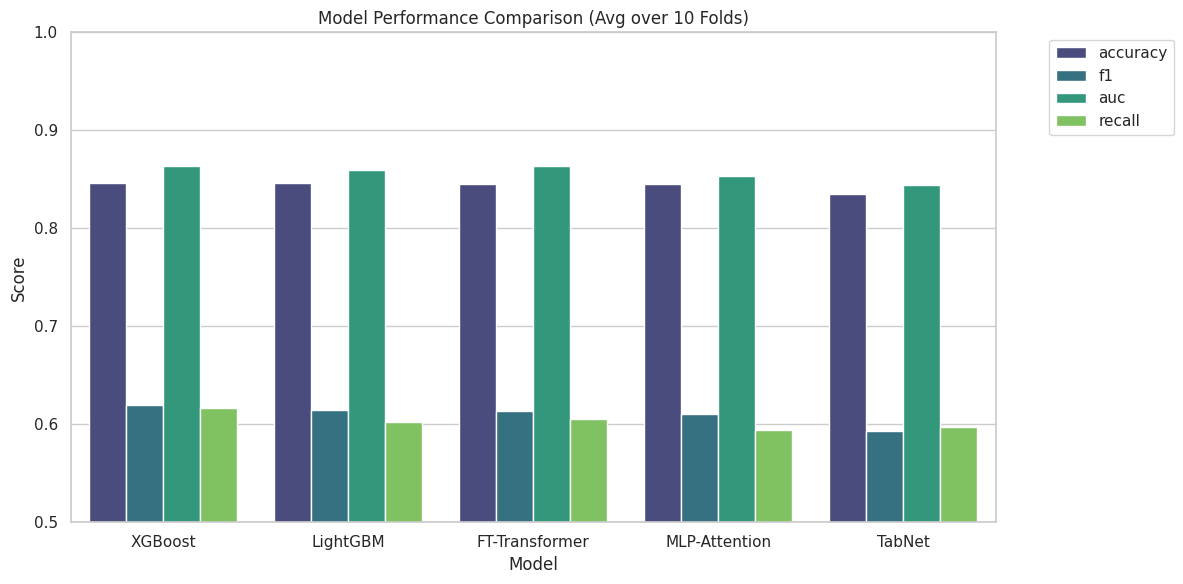

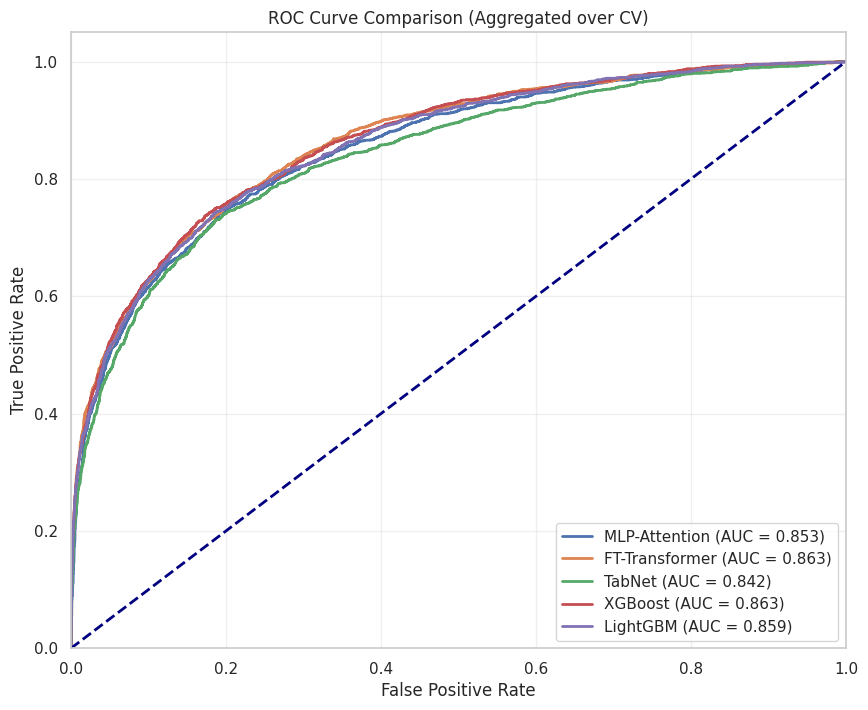

In [ ]:
if len(results_summary) > 0:
        print("\n\n" + "="*80)
        print("FINAL CHAMPIONSHIP LEADERBOARD")
        print("="*80)

        df_results = pd.DataFrame(results_summary).T
        if "f1" in df_results.columns:
            df_results = df_results.sort_values(by="f1", ascending=False)
        print(df_results)
        print("="*80)
        print(f"WINNER: {df_results.index[0]}")

        # --- PLOT 1: Performance Metrics Comparison ---
        plt.figure(figsize=(12, 6))
        # Melt dataframe for seaborn
        df_melted = df_results.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
        # Filter for key metrics to avoid clutter
        key_metrics = ['accuracy', 'f1', 'auc', 'recall']
        df_melted = df_melted[df_melted['Metric'].isin(key_metrics)]

        sns.barplot(data=df_melted, x='index', y='Score', hue='Metric', palette='viridis')
        plt.title('Model Performance Comparison (Avg over 10 Folds)')
        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.ylim(0.5, 1.0) # Zoom in on the top half
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # --- PLOT 2: ROC Curves ---
        plt.figure(figsize=(10, 8))
        for name, (y_t, y_p) in roc_data.items():
            fpr, tpr, _ = roc_curve(y_t, y_p)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison (Aggregated over CV)')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.show()

/tmp/ipython-input-1383154259.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


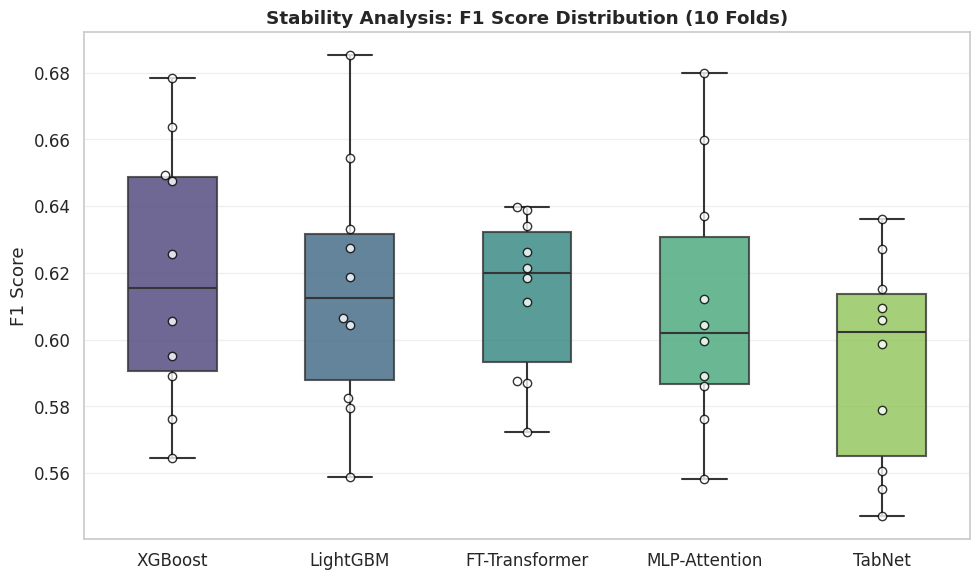

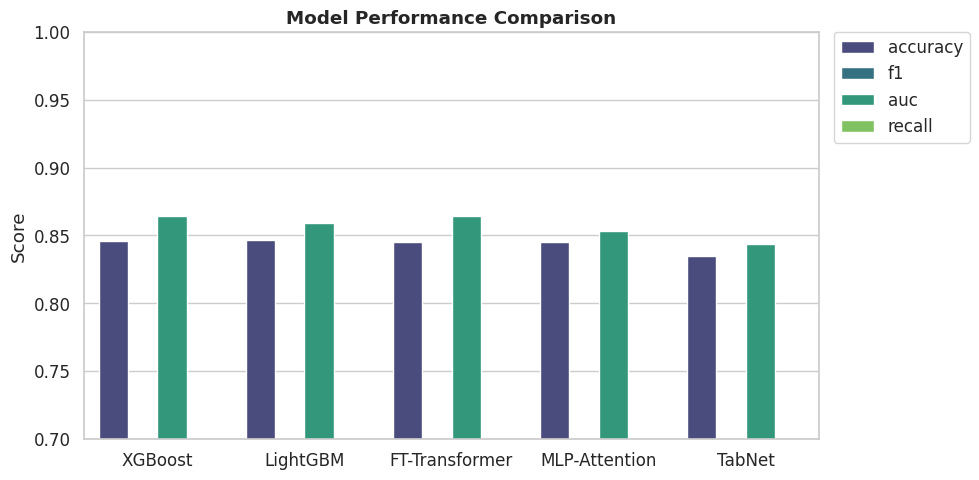

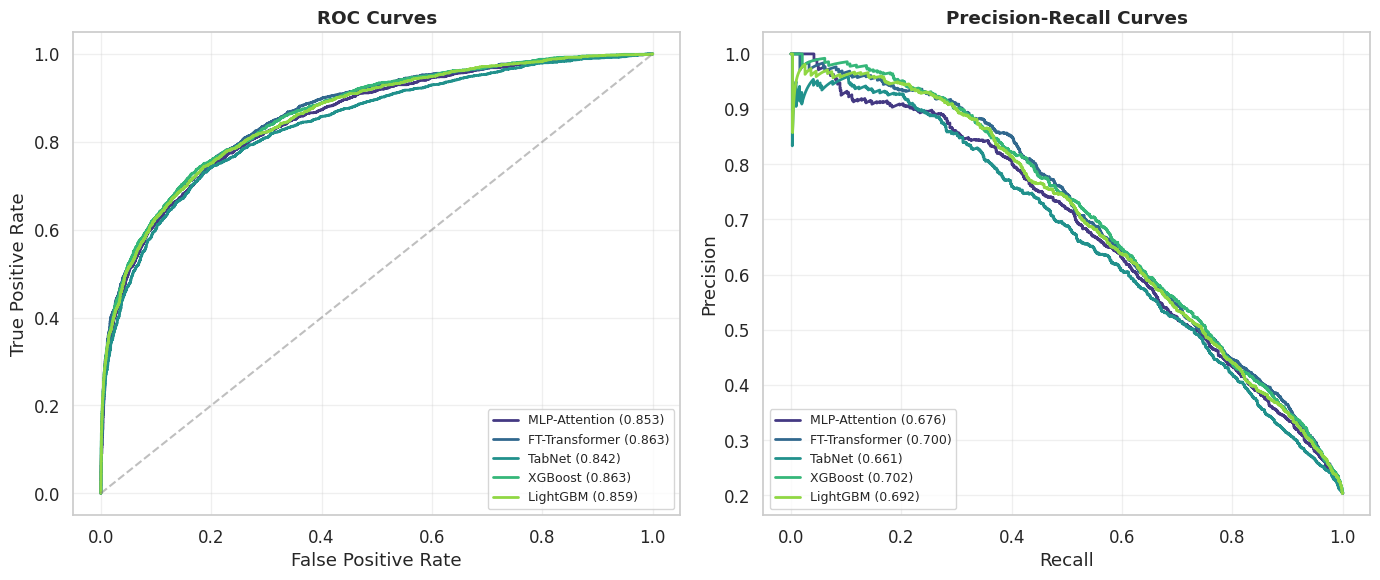

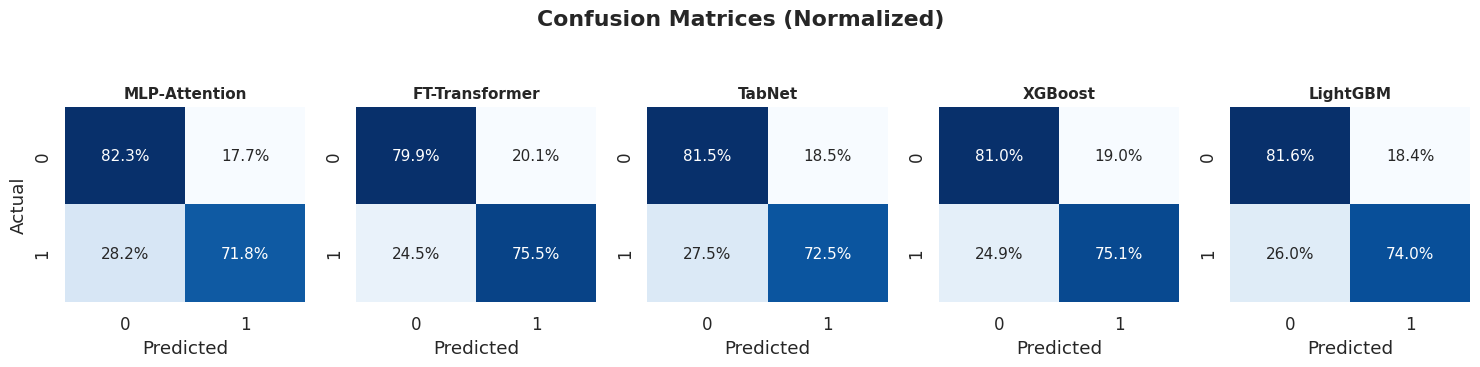

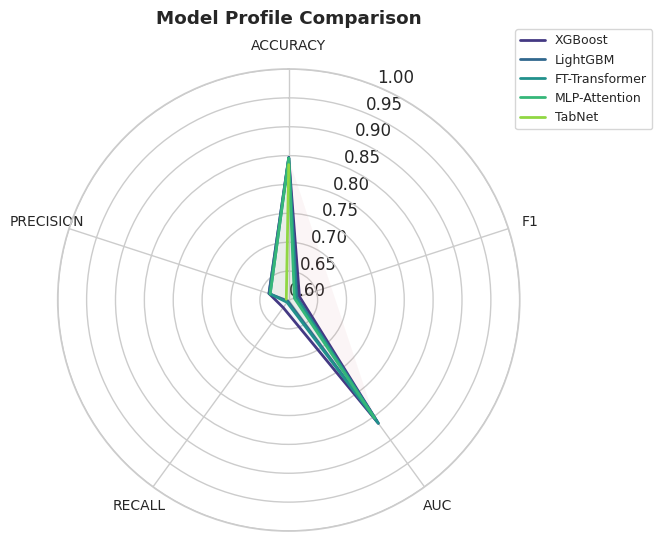

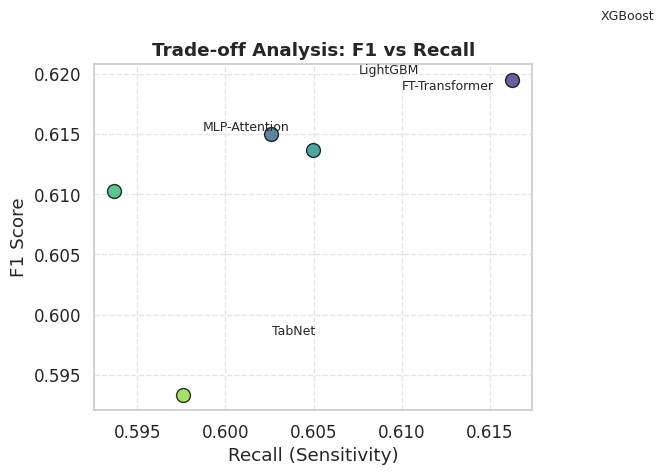

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import pi
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# --- 1. SETUP STYLE FOR PAPER ---
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1) # Cleaner, smaller fonts
palette = sns.color_palette("viridis", n_colors=len(roc_data))

# --------------------------------------------
# 0. STABILITY ANALYSIS (BOX PLOT)
# --------------------------------------------
if 'raw_metrics_storage' in locals() and raw_metrics_storage:
    plt.figure(figsize=(10, 6))

    box_data = []
    for model_name, scores in raw_metrics_storage.items():
        for score in scores:
            box_data.append({'Model': model_name, 'F1 Score': score})

    df_box = pd.DataFrame(box_data)

    # CRITICAL FIX: Sort the box plot by the same order as the leaderboard
    # This ensures colors match between the Bar Plot and Box Plot
    order_by_f1 = df_results.index if 'df_results' in locals() else None

    # 1. The Box Plot
    sns.boxplot(
        data=df_box,
        x='Model',
        y='F1 Score',
        order=order_by_f1,
        palette='viridis',
        width=0.5,
        linewidth=1.5,
        boxprops=dict(alpha=0.8)
    )

    # 2. The Swarm Plot
    sns.swarmplot(
        data=df_box,
        x='Model',
        y='F1 Score',
        order=order_by_f1,
        color='white',
        edgecolor='black',
        linewidth=1,
        alpha=0.8,
        size=6
    )

    plt.title("Stability Analysis: F1 Score Distribution (10 Folds)", fontweight='bold')
    plt.ylabel("F1 Score")
    plt.xlabel("")
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Box Plot: 'raw_metrics_storage' not found.")

# --------------------------------------------
# 1. CLEAN METRIC BAR PLOT (COMPACT)
# --------------------------------------------
plt.figure(figsize=(10, 5)) # Much smaller, cleaner size

# Reshape data for Seaborn
df_melted = df_results[['accuracy', 'f1', 'auc', 'recall']].reset_index().melt(
    id_vars='index', var_name='Metric', value_name='Score'
)

ax = sns.barplot(
    data=df_melted,
    x='index',
    y='Score',
    hue='Metric',
    palette='viridis'
)

plt.title("Model Performance Comparison", fontweight='bold')
plt.xlabel("") # Remove 'Model' label (names are enough)
plt.ylabel("Score")
plt.ylim(0.7, 1.0) # Zoom in on the relevant range
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

# --------------------------------------------
# 2. ROC & PRECISION-RECALL (SIDE-BY-SIDE)
# --------------------------------------------
# Combining these into one figure saves space in a paper
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Left: ROC Curve ---
for i, (model_name, (y_true, y_prob)) in enumerate(roc_data.items()):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, color=palette[i], label=f"{model_name} ({roc_auc:.3f})")

axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.5)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves", fontweight="bold")
axes[0].legend(loc="lower right", fontsize=9)
axes[0].grid(alpha=0.3)

# --- Right: Precision-Recall ---
for i, (model_name, (y_true, y_prob)) in enumerate(roc_data.items()):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, lw=2, color=palette[i], label=f"{model_name} ({pr_auc:.3f})")

axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curves", fontweight="bold")
axes[1].legend(loc="lower left", fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --------------------------------------------
# 3. NORMALIZED CONFUSION MATRICES (GRID)
# --------------------------------------------
n_models = len(roc_data)
# Dynamic sizing: 3 inches wide per subplot
fig, axes = plt.subplots(1, n_models, figsize=(3 * n_models, 3.5))

if n_models == 1: axes = [axes]

for ax, (model_name, (y_true, y_prob)) in zip(axes, roc_data.items()):
    y_pred = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    sns.heatmap(
        cm,
        annot=True,
        fmt=".1%", # Show as percentages (easier to read)
        cmap="Blues",
        cbar=False,
        ax=ax,
        annot_kws={"size": 11}
    )
    ax.set_title(model_name, fontsize=11, fontweight='bold')
    ax.set_xlabel("Predicted")
    if ax == axes[0]: ax.set_ylabel("Actual") # Only show Y label on first plot
    else: ax.set_ylabel("")

plt.suptitle("Confusion Matrices (Normalized)", y=1.05, fontweight="bold")
plt.tight_layout()
plt.show()

# --------------------------------------------
# 4. RADAR CHART (COMPACT)
# --------------------------------------------
metrics_for_radar = ['accuracy', 'f1', 'auc', 'recall', 'precision']
labels = [m.upper() for m in metrics_for_radar]
num_vars = len(labels)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, model in enumerate(df_results.index):
    values = df_results.loc[model, metrics_for_radar].values.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=palette[i])
    ax.fill(angles, values, alpha=0.05)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=10)
ax.set_ylim(0.6, 1.0) # Zoom in to show differences
plt.title("Model Profile Comparison", fontweight="bold", y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
plt.show()

# --------------------------------------------
# 5. F1 vs RECALL TRADEOFF
# --------------------------------------------
plt.figure(figsize=(7, 5))

for i, model in enumerate(df_results.index):
    x = df_results.loc[model, 'recall']
    y = df_results.loc[model, 'f1']

    plt.scatter(x, y, s=100, color=palette[i], edgecolors='black', label=model, alpha=0.8)

    # Smart labelling to avoid overlap
    plt.text(x + 0.005, y + 0.005, model, fontsize=9)

plt.xlabel("Recall (Sensitivity)")
plt.ylabel("F1 Score")
plt.title("Trade-off Analysis: F1 vs Recall", fontweight="bold")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

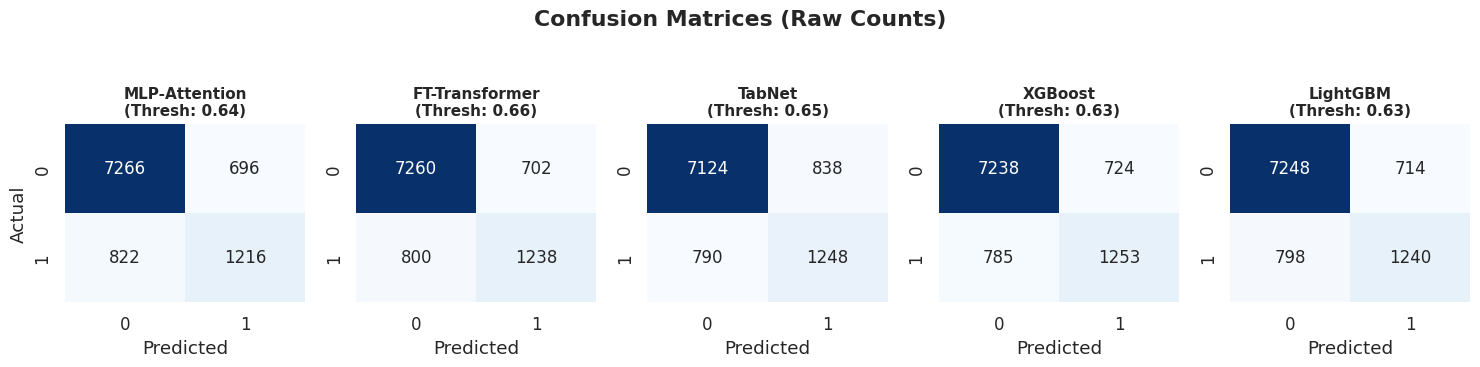

In [ ]:
# --------------------------------------------
# 3. CONFUSION MATRICES (RAW COUNTS)
# --------------------------------------------
n_models = len(roc_data)
fig, axes = plt.subplots(1, n_models, figsize=(3 * n_models, 3.5))

if n_models == 1: axes = [axes]

for ax, (model_name, (y_true, y_prob)) in zip(axes, roc_data.items()):

    # Use the saved threshold if it exists, otherwise default to 0.5
    # (If you haven't re-run training yet, this will default to 0.5)
    thresh = final_thresholds.get(model_name, 0.5) if 'final_thresholds' in locals() else 0.5

    y_pred = (y_prob >= thresh).astype(int)

    # --- CHANGE 1: Remove 'normalize' argument to get raw counts ---
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",      # --- CHANGE 2: 'd' stands for Integer (no decimals/percents) ---
        cmap="Blues",
        cbar=False,
        ax=ax,
        annot_kws={"size": 12}
    )

    ax.set_title(f"{model_name}\n(Thresh: {thresh:.2f})", fontsize=11, fontweight='bold')

    ax.set_xlabel("Predicted")
    if ax == axes[0]: ax.set_ylabel("Actual")
    else: ax.set_ylabel("")

plt.suptitle("Confusion Matrices (Raw Counts)", y=1.05, fontweight="bold")
plt.tight_layout()
plt.show()

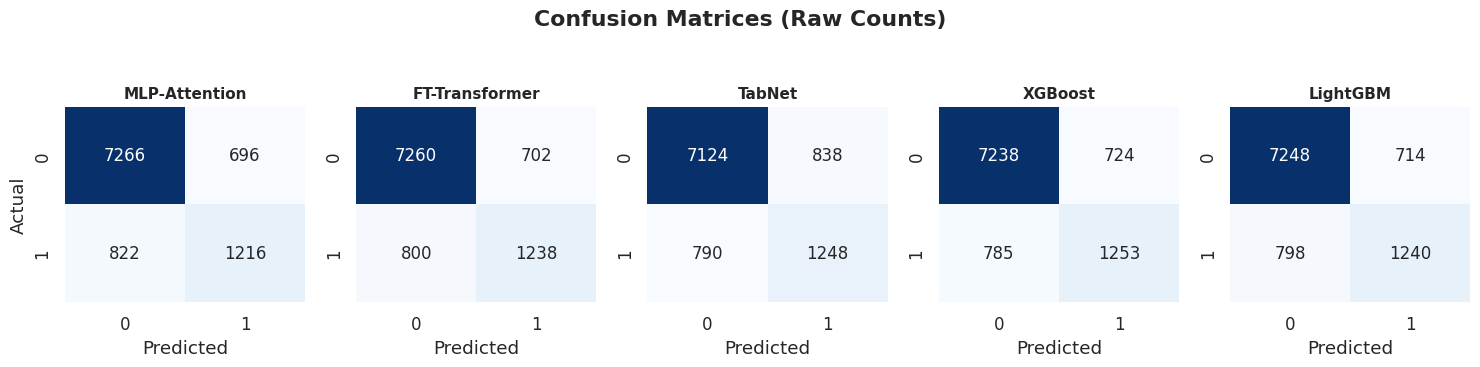

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --------------------------------------------
# 3. CONFUSION MATRICES (RAW COUNTS)
# --------------------------------------------
n_models = len(roc_data)
fig, axes = plt.subplots(1, n_models, figsize=(3 * n_models, 3.5))

if n_models == 1: axes = [axes]

for ax, (model_name, (y_true, y_prob)) in zip(axes, roc_data.items()):

    # Use the saved threshold if it exists, otherwise default to 0.5
    thresh = final_thresholds.get(model_name, 0.5) if 'final_thresholds' in locals() else 0.5

    y_pred = (y_prob >= thresh).astype(int)

    # Calculate raw counts (no normalization)
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",      # 'd' ensures raw integers are displayed
        cmap="Blues",
        cbar=False,
        ax=ax,
        annot_kws={"size": 12}
    )

    # --- UPDATED: Title now contains ONLY the model name ---
    ax.set_title(model_name, fontsize=11, fontweight='bold')

    ax.set_xlabel("Predicted")
    if ax == axes[0]: ax.set_ylabel("Actual")
    else: ax.set_ylabel("")

plt.suptitle("Confusion Matrices (Raw Counts)", y=1.05, fontweight="bold")
plt.tight_layout()
plt.show()

Generating SHAP explanations...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-2573292373.py:27: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_shap, feature_names=X_raw.columns, show=False)


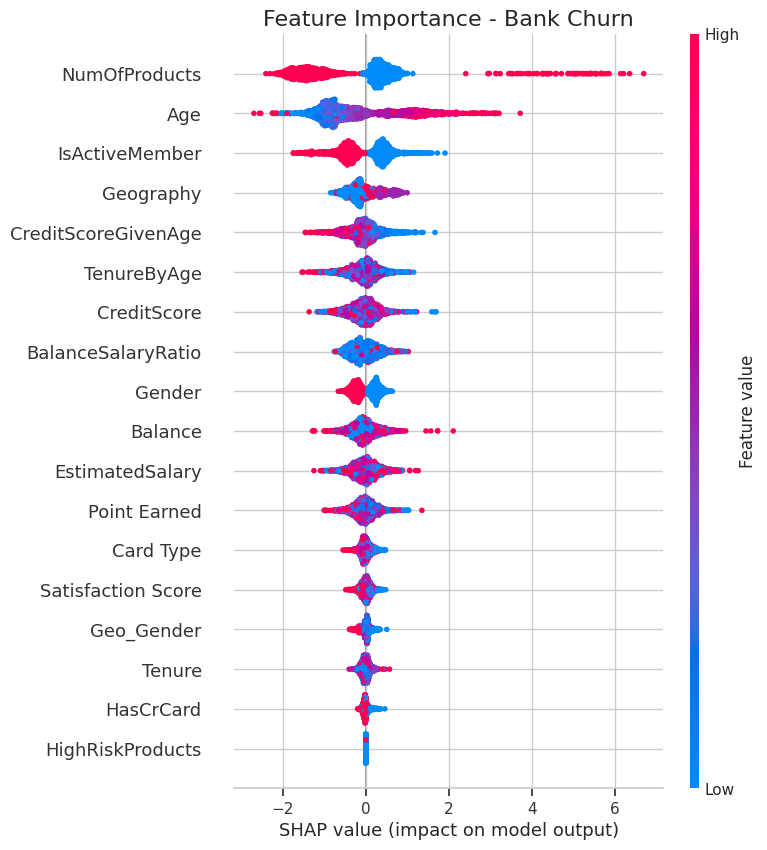

Graph saved as SHAP_Bank_Summary.png


In [ ]:
# ==========================================
# SHAP Analysis (Bank Churn)
# ==========================================
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print("Generating SHAP explanations...")

# 1. Prepare Split
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# 2. Train Model
model_shap = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_shap.fit(X_train_shap, y_train_shap)

# 3. Calculate SHAP
explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X_test_shap)

# 4. Generate & Save Plot
plt.figure(figsize=(10, 8))
# X_raw.columns comes from your data loading cell
shap.summary_plot(shap_values, X_test_shap, feature_names=X_raw.columns, show=False)
plt.title("Feature Importance - Bank Churn", fontsize=16)
plt.tight_layout()
plt.savefig("SHAP_Bank_Summary.png", dpi=300)
plt.show()

print("Graph saved as SHAP_Bank_Summary.png")